In [1]:
import math
import csv
import os
import random 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader


# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

This  experiment is made in order to test the possibility to use a single feature for PD and Control classification with a LSTM.
Single feature here is Frequency, with index 1. 

In [2]:
class PDControlDataset(Dataset):
    """Neurogenertive features dataset."""

    def __init__(self, csv_file, root_dir,feature_idx = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
           
        """
        self.df = pd.read_csv(csv_file) # 
        self.root_dir = root_dir
        self.feature_idx = feature_idx
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path = os.path.join(self.root_dir,
                                self.df.iloc[idx, 1])
        label = self.convert_label(self.df.iloc[idx, 2])
        features  = pd.read_csv(file_path,  header=None).values
        if self.feature_idx is not None:
            features = features[self.feature_idx,:]
        sample = {'data': features, 'label': label}


        return sample
    
    def convert_label(self, label):
        if label == 'control':
            return 0
        elif label == 'PDL':
            return 1
        elif label == 'PDR':
            return 1
        else:
            raise Exception('ONLY control, PDL, PDR are currently supported')

In [3]:
folder_p = 'C:/Users/KHOKHLOVAM/Documents/projects/kotelnikov/data/lstm_trials/n200_4_features/'              
dataset = PDControlDataset(folder_p +'/all_data_200N.csv', root_dir=folder_p, feature_idx=0)

In [4]:
# check data statistics
labels = [0]*len(dataset)
for i in range(len(dataset)):
    sample = dataset[i]
    labels[i] = sample['label']
    # print(sample['data'].shape)
values, counts = np.unique(labels, return_counts=True)
print(values, counts)

[0 1] [ 39 104]


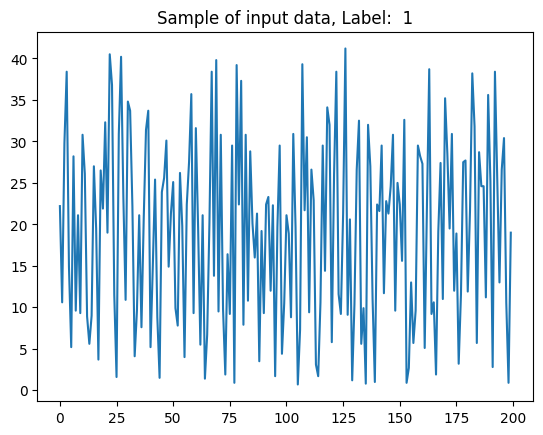

In [7]:
# plot random data 
m = random.randint(0, len(dataset))
for i in range(len(dataset)):
    sample = dataset[i]
    labels[i] = sample['label']
    data = sample['data']
    if i==m:
        plt.plot(data)
        plt.title(f'Sample of input data, Label:  {labels[i]}')
    # print(sample['data'].shape)

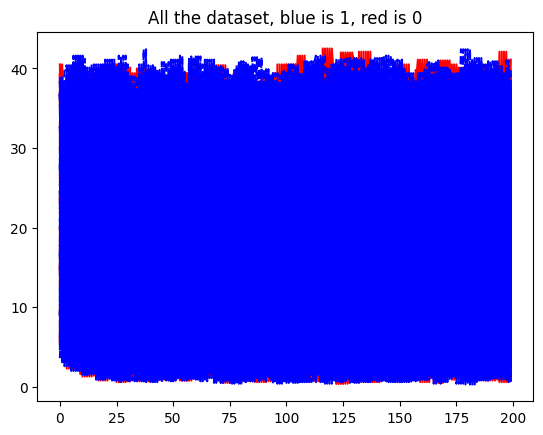

In [6]:
# plot all data
for i in range(len(dataset)):
    sample = dataset[i]
    labels[i] = sample['label']
    data = sample['data']
    if labels[i]==0:
        plt.plot(data, 'r')
    else:
        plt.plot(data, 'b', linestyle='dashed')
    
plt.title(f'All the dataset, blue is 1, red is 0')
plt.show()


Try Fourier transform

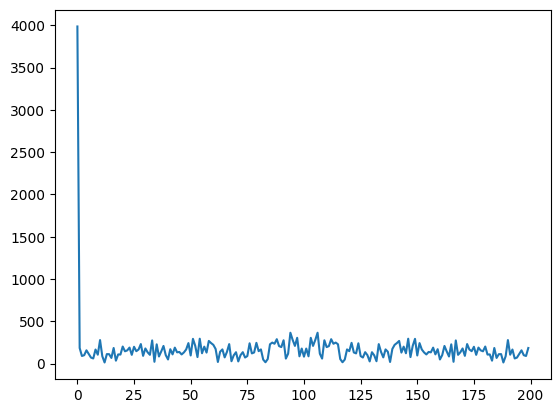

In [8]:
from scipy.fft import fft, fftfreq
xf = fft(dataset[0]['data'])
plt.plot(np.abs(xf))

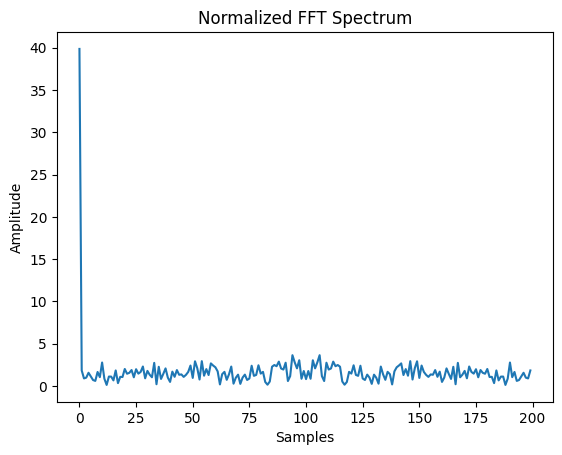

In [9]:
# Calculate N/2 to normalize the FFT output
N = len(xf)
normalize = N/2

# Plot the normalized FFT (|Xk|)/(N/2)
plt.plot(np.abs(xf)/normalize)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Normalized FFT Spectrum')
plt.show()

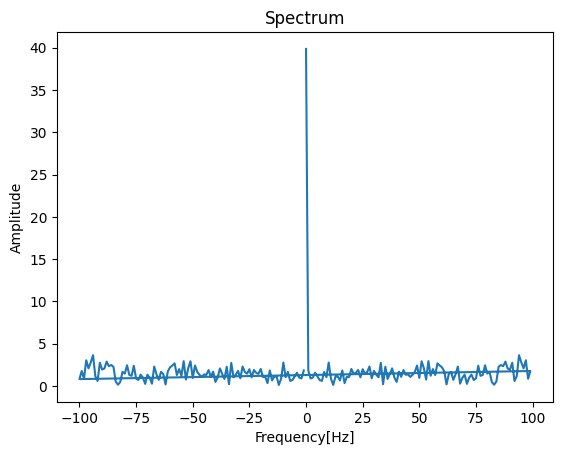

In [10]:
# Get the frequency components of the spectrum
sampling_rate = 200.0 # It's used as a sample spacing
frequency_axis = fftfreq(N, d=1.0/sampling_rate)
norm_amplitude = np.abs(xf)/normalize
# Plot the results
plt.plot(frequency_axis, norm_amplitude)
plt.xlabel('Frequency[Hz]')
plt.ylabel('Amplitude')
plt.title('Spectrum')
plt.show()

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex val

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex val

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex val

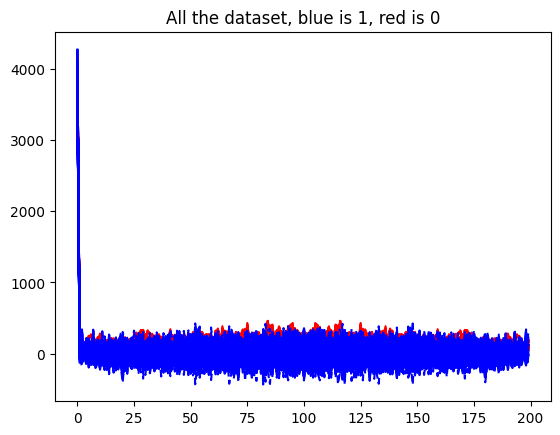

In [11]:
# plot all data
for i in range(len(dataset)):
    sample = dataset[i]
    labels[i] = sample['label']
    data = sample['data']
    if labels[i]==0:
        plt.plot(abs(fft(data)), 'r')
    else:
        plt.plot(fft(data), 'b', linestyle='dashed')
    
plt.title(f'All the dataset, blue is 1, red is 0')
plt.show()


## Experiment one:  No data augmentation for the class which is under represented! 

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class LSTM(nn.Module):

    def __init__(self, dimension=64, input_size = 4, num_layers = 1, drop_rate = 0):
        super(LSTM, self).__init__()

        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=dimension,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=drop_rate)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, X, N=200):
        ''' N is the legnth of a feature vector'''
        lstm_output, _ = self.lstm(X)

        out_forward = lstm_output[range(len(lstm_output)), N - 1, :self.dimension]
        out_reverse = lstm_output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        X_fea = self.drop(out_reduced)

        X_fea = self.fc(X_fea)
        X_fea = torch.squeeze(X_fea, 1)
        out =  torch.sigmoid(X_fea)


        return out

In [13]:
# Training Function
def train(model,
          optimizer,
          train_iter,
          val_iter,
          criterion = nn.BCELoss(),
          num_epochs = 10,
          best_valid_loss = float("Inf")):
    
    eval_every = len(train_iter)
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    accuracy_train = []
    accuracy_val = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total_correct_t = 0 
        total_predicted_t = 0
        for  data in train_iter:  
            labels = data['label'].double().to(device)
            X  = data['data']
            X= torch.unsqueeze(X, dim=1)
            X = torch.transpose(X,2,1).double().to(device)
            output = model(X)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #accuracy train metric
            classifications_t = output.round() #binary accuracy
            #print(classifications_t, labels)
            correct_predictions_t = sum(classifications_t==labels).item()
            total_correct_t += correct_predictions_t
            total_predicted_t += len(labels)        

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            total_correct = 0
            total_predicted = 0
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for  data in val_iter:           
                      labels = data['label'].double().to(device)
                      X  = data['data']
                      X = torch.unsqueeze(X, dim=1)
                      X = torch.transpose(X,2,1).double().to(device)
                      output = model(X)
                      loss = criterion(output, labels)
                      classifications = output.round() #binary accuracy
                      correct_predictions = sum(classifications==labels).item()
                      total_correct += correct_predictions
                      total_predicted += len(labels)                        
                      valid_running_loss += loss.item()
                        

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(train_iter)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                accuracy_val.append(total_correct/total_predicted)
                
                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f} Accuracy: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              average_train_loss, average_valid_loss, total_correct/total_predicted))
                
#                 # checkpoint
#                 if best_valid_loss > average_valid_loss:
#                     best_valid_loss = average_valid_loss
#                     save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
#                     save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
        accuracy_train.append(total_correct_t/total_predicted_t)
        print(f'Train accuracy {total_correct_t/total_predicted_t}')
    
#     save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Loss and Accuracy plots')
    ax1.title.set_text('Train (R) and valid losses (B dashed)')
    ax1.plot(train_loss_list,'r',valid_loss_list, '--b')
    ax2.plot(accuracy_train,'r', accuracy_val, '--b')  
    ax1.title.set_text('Train (R) and valid accuracies (B dashed)')


In [14]:
def validate(model, val_iter)->tuple():
    ''' verify the model'''
    model.eval()
    y = []
    y_hat = []
    total_correct = 0
    total_predicted = 0
    with torch.no_grad():                    
          # validation loop
          for  data in val_iter:           
              labels = data['label'].double().to(device)
              X  = data['data']
              X = torch.unsqueeze(X, dim=1)
              X = torch.transpose(X,2,1).to(device)
              output = model(X)              
              classifications = output.round() #binary accuracy
              correct_predictions = sum(classifications==labels).item()
              total_correct += correct_predictions
              total_predicted += len(labels) 
              y.extend(labels.tolist())
              y_hat.extend(classifications.tolist())
    print(f"Accuracy: {total_correct/total_predicted}")
    return (y,y_hat)      

In [15]:
model = LSTM(input_size = 1, num_layers = 4, drop_rate = 0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 2

In [16]:
from torch.utils.data import  random_split
train_data, test_data = random_split(dataset, [127,16], generator=torch.Generator().manual_seed(162))

In [17]:
train_iter = DataLoader(train_data, batch_size=batch_size) 
val_iter = DataLoader(test_data, batch_size=batch_size) 

Accuracy: 0.625


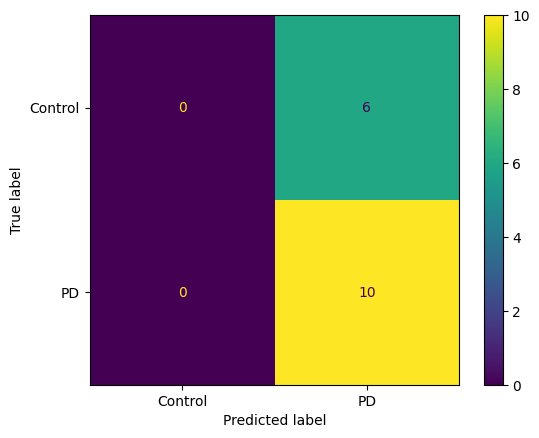

In [18]:
### Before training, what model predicts on val data
y,y_predictions =  validate(model.to(device).double(), val_iter)
# creating a confusion matrix
cm = confusion_matrix(y, y_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
disp.plot()
plt.show()

Accuracy: 0.7401574803149606


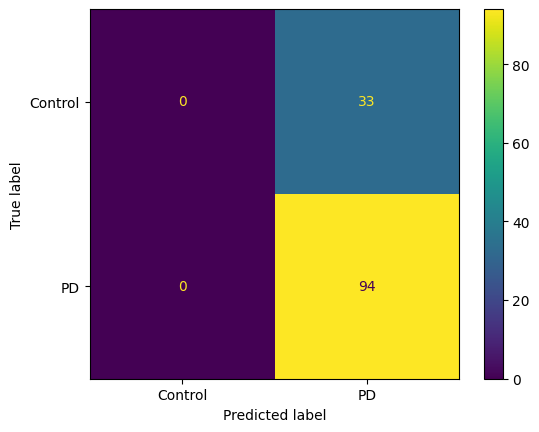

In [19]:
### Before training, what model predicts on train data
y,y_predictions =  validate(model.to(device).double(), train_iter)
# creating a confusion matrix
cm = confusion_matrix(y, y_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
disp.plot()
plt.show()

Epoch [1/25], Step [64/1600], Train Loss: 0.7002, Valid Loss: 0.0844 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [2/25], Step [128/1600], Train Loss: 0.5960, Valid Loss: 0.0848 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [3/25], Step [192/1600], Train Loss: 0.5914, Valid Loss: 0.0849 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [4/25], Step [256/1600], Train Loss: 0.5900, Valid Loss: 0.0849 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [5/25], Step [320/1600], Train Loss: 0.5890, Valid Loss: 0.0850 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [6/25], Step [384/1600], Train Loss: 0.5882, Valid Loss: 0.0850 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [7/25], Step [448/1600], Train Loss: 0.5877, Valid Loss: 0.0851 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [8/25], Step [512/1600], Train Loss: 0.5872, Valid Loss: 0.0851 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [9/25], Step [576/1600], Tr

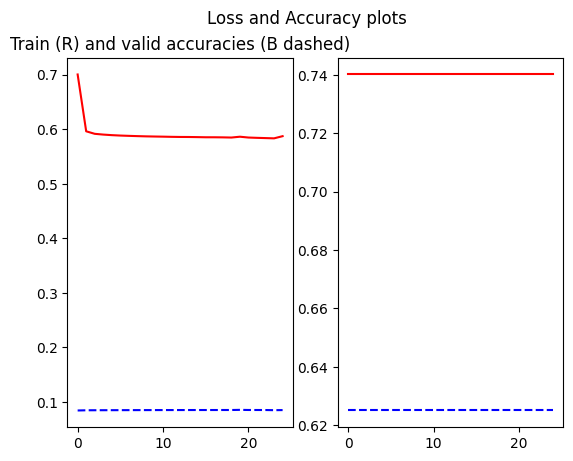

In [20]:
train(model=model.to(device).double(), optimizer=optimizer,train_iter=train_iter, val_iter=val_iter, num_epochs=25)

###  After train, what model predicts

Accuracy: 0.625


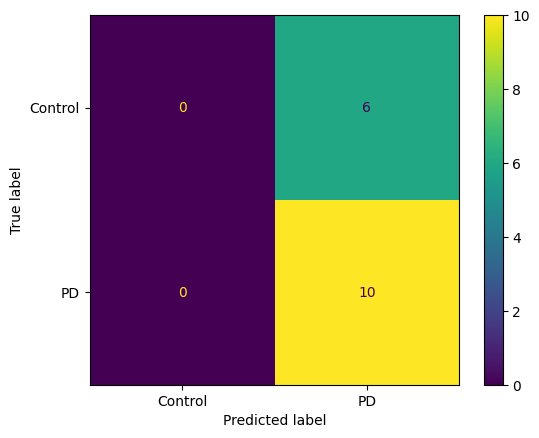

In [21]:
y,y_predictions =  validate(model.to(device).double(), val_iter)
# creating a confusion matrix
cm = confusion_matrix(y, y_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
disp.plot()
plt.show()

### Try various options and model specifications 

#### Batch size
Doesn't affect the model, it always converges to the main class predictions. Values tried:
* 4
* 8
* 1
#### Number of hidden units in a layer
Doesn't affect the model, it always converges to the main class predictions. Values tried for hidden_dim:
* 64
* 128
#### Number of LSTM cells
Only 1,2 and 4 cells were tested. No difference observed with a classical loss. With a unbalansed loss (BCEwithdigits), few cells gave lower results, but the trend changes.
#### Batch normalization and drop rate
Fisrt models had drop rate 0.5, later models are tried without dropout (drop rate = 0). They still do not train, so batch norm is not an issue here.
#### Add batchnorm regularisation
To check if the same as batch normalisation. Not tested.

## Different model, just to be sure that there is no error in the model itself

Model from [here](https://saturncloud.io/blog/how-to-use-lstm-in-pytorch-for-classification/).
It is a very similar model, but with only a forward pass (unlike the previous model). It is just check to see if there were no errors in the model definition somewhere.


In [122]:
class LSTMModel_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel_2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out

In [144]:
batch_size = 4
train_iter = DataLoader(train_data, batch_size=batch_size) 
val_iter = DataLoader(test_data, batch_size=batch_size) 

Epoch [1/20], Step [10/35], Loss: 0.6604
Epoch [1/20], Step [10/35], Accuracy: 0.8500
Epoch [1/20], Step [20/35], Loss: 0.6486
Epoch [1/20], Step [20/35], Accuracy: 0.7375
Epoch [1/20], Step [30/35], Loss: 0.5768
Epoch [1/20], Step [30/35], Accuracy: 0.7500
Epoch [2/20], Step [10/35], Loss: 0.6107
Epoch [2/20], Step [10/35], Accuracy: 0.8500
Epoch [2/20], Step [20/35], Loss: 0.6082
Epoch [2/20], Step [20/35], Accuracy: 0.7375
Epoch [2/20], Step [30/35], Loss: 0.4712
Epoch [2/20], Step [30/35], Accuracy: 0.7500
Epoch [3/20], Step [10/35], Loss: 0.5659
Epoch [3/20], Step [10/35], Accuracy: 0.8500
Epoch [3/20], Step [20/35], Loss: 0.5783
Epoch [3/20], Step [20/35], Accuracy: 0.7375
Epoch [3/20], Step [30/35], Loss: 0.3711
Epoch [3/20], Step [30/35], Accuracy: 0.7500
Epoch [4/20], Step [10/35], Loss: 0.5503
Epoch [4/20], Step [10/35], Accuracy: 0.8500
Epoch [4/20], Step [20/35], Loss: 0.5714
Epoch [4/20], Step [20/35], Accuracy: 0.7375
Epoch [4/20], Step [30/35], Loss: 0.3362
Epoch [4/20],

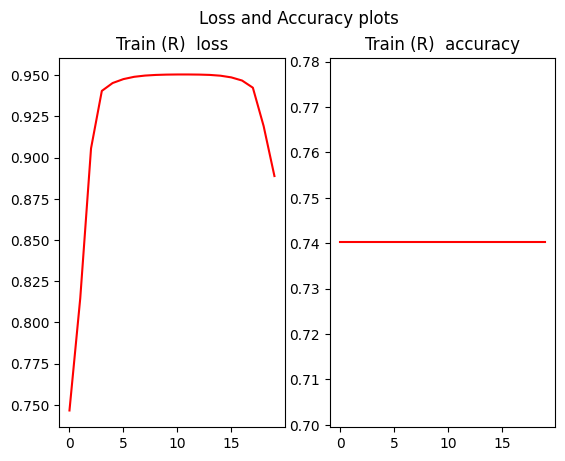

In [145]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel_2(input_size=1, hidden_size=20, num_layers=1, num_classes=2).to(device).float()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_loss_list = []
accuracy_train = []


for epoch in range(num_epochs):
     total_correct = 0
     total_predicted = 0
     for  i, data in enumerate(train_iter):  
        labels = data['label'].long().to(device)
        X  = data['data']
        X= torch.unsqueeze(X, dim=1)
        inputs = torch.transpose(X,2,1).float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        
        # accuracy
        classifications = torch.argmax(outputs,1) #binary accuracy
        #print(f'ooutput {classifications}, true label {labels}')
        correct_predictions = sum(classifications==labels).item()
        total_correct += correct_predictions
        total_predicted += len(labels) 

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.item()))
            print('Epoch [{}/{}], Step [{}/{}], Accuracy: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(dataset)//batch_size, total_correct/total_predicted))
     train_loss_list.append(loss.item())
     accuracy_train.append(total_correct/total_predicted)
print('Finished Training!')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy plots')
ax1.title.set_text('Train (R)  loss')
ax1.plot(train_loss_list,'r')
ax2.plot(accuracy_train,'r')  
ax2.title.set_text('Train (R)  accuracy')


This model gives exactly the same results for training with a different model, and yet another model was tested previously.
Each and every model learns to predict ones (only one dominant class) starting from some moment in time: output tensor([1, 1, 1, 1]), true label tensor([1, 1, 1, 1]). 
At this point, the problem can be:

    * the data, maybe there is an error in them
    * the fact that the features we used cannot be exploited by a Neural Network

## Different Loss Functions
Loss functions can be also used to compensate for the fact that the dataset is not well-balanced.
For imbalanced datasets, where number of instances in one class is significantly smaller than other, [torch.nn.BCEWithLogitsLoss](https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75) function can be modified by adding a weight parameter to loss function. The weight parameter allows to assign different weights for the positive and negative classes.

Here I add the penalty for under represented class 0 (control).

In [221]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = torch.ones([2])  
weight[0] = 3 # higher weight for Control patient  class
criterion = nn.BCEWithLogitsLoss(weight=weight,reduction='sum')
model_2 = LSTMModel_2(input_size=1, hidden_size=64, num_layers=2, num_classes=2).to(device).float()
optimizer = optim.SGD(model_2.parameters(), lr=0.001)

num_epochs = 20

Same training loop as before, but I added the encoding of labels, so that we can use the logit loss. 
Precisely, the labels should be given one-hot encoded, as in [this example](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html)

In [222]:
batch_size = 4
train_iter = DataLoader(train_data, batch_size=batch_size) 
val_iter = DataLoader(test_data, batch_size=batch_size) 

Epoch [1/20], Step [10/35], Loss: 10.9207
Epoch [1/20], Step [10/35], Accuracy: 0.8500
Epoch [1/20], Step [20/35], Loss: 10.9188
Epoch [1/20], Step [20/35], Accuracy: 0.7375
Epoch [1/20], Step [30/35], Loss: 10.7399
Epoch [1/20], Step [30/35], Accuracy: 0.7500
Epoch [2/20], Step [10/35], Loss: 10.9207
Epoch [2/20], Step [10/35], Accuracy: 0.8500
Epoch [2/20], Step [20/35], Loss: 10.9188
Epoch [2/20], Step [20/35], Accuracy: 0.7375
Epoch [2/20], Step [30/35], Loss: 10.7399
Epoch [2/20], Step [30/35], Accuracy: 0.7500
Epoch [3/20], Step [10/35], Loss: 10.9207
Epoch [3/20], Step [10/35], Accuracy: 0.8500
Epoch [3/20], Step [20/35], Loss: 10.9188
Epoch [3/20], Step [20/35], Accuracy: 0.7375
Epoch [3/20], Step [30/35], Loss: 10.7399
Epoch [3/20], Step [30/35], Accuracy: 0.7500
Epoch [4/20], Step [10/35], Loss: 10.9207
Epoch [4/20], Step [10/35], Accuracy: 0.8500
Epoch [4/20], Step [20/35], Loss: 10.9188
Epoch [4/20], Step [20/35], Accuracy: 0.7375
Epoch [4/20], Step [30/35], Loss: 10.7399
E

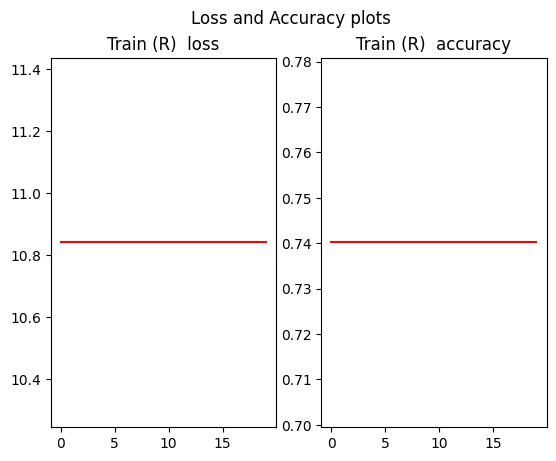

In [223]:
train_loss_list = []
accuracy_train = []


for epoch in range(num_epochs):
     total_correct = 0
     total_predicted = 0
     total_loss = 0
     for  i, data in enumerate(train_iter):  
        labels = data['label'].long().to(device)
        X  = data['data']
        X= torch.unsqueeze(X, dim=1)
        inputs = torch.transpose(X,2,1).float().to(device)
        outputs = model_2(inputs)
        encoded_labels = torch.zeros(len(labels),2).float()
        for f in range(len(labels)):
            if labels[f]==0:
                encoded_labels[f,0] = 1
            else:
                encoded_labels[f,1] = 1
        # print(labels, encoded_labels)
            
        loss = criterion(outputs, encoded_labels)
        
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()
        total_loss += loss.item()    
        
        
        # accuracy
        classifications = torch.argmax(outputs,1) #binary accuracy
        #print(f'ooutput {classifications}, true label {labels}')
        correct_predictions = sum(classifications==labels).item()
        total_correct += correct_predictions
        total_predicted += len(labels) 

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.item()))
            print('Epoch [{}/{}], Step [{}/{}], Accuracy: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(dataset)//batch_size, total_correct/total_predicted))
     
     accuracy_train.append(total_correct/total_predicted)
     train_loss_list.append(total_loss/(len(train_iter)))
print('Finished Training!')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy plots')
ax1.title.set_text('Train (R)  loss')
ax1.plot(train_loss_list,'r')
ax2.plot(accuracy_train,'r')  
ax2.title.set_text('Train (R)  accuracy')


In [228]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class LSTM(nn.Module):

    def __init__(self, dimension=64, input_size = 4, num_layers = 1, drop_rate = 0):
        super(LSTM, self).__init__()

        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=dimension,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=drop_rate)

        self.fc = nn.Linear(2*dimension, 2)

    def forward(self, X, N=200):
        ''' N is the legnth of a feature vector'''
        lstm_output, _ = self.lstm(X)

        out_forward = lstm_output[range(len(lstm_output)), N - 1, :self.dimension]
        out_reverse = lstm_output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        X_fea = self.drop(out_reduced)

        X_fea = self.fc(X_fea)
        X_fea = torch.squeeze(X_fea, 1)

        return X_fea

In [244]:
# Training Function
def train_logitloss(model,
          optimizer,
          train_iter,
          val_iter,
          criterion = nn.BCELoss(),
          num_epochs = 10,
          best_valid_loss = float("Inf")):
    
    eval_every = len(train_iter)
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    accuracy_train = []
    accuracy_val = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total_correct_t = 0 
        total_predicted_t = 0
        for  data in train_iter:  
            labels = data['label'].double().to(device)
            X  = data['data']
            X= torch.unsqueeze(X, dim=1)
            X = torch.transpose(X,2,1).double().to(device)
            output = model(X)
            
            encoded_labels = torch.zeros(len(labels),2).float()
            for f in range(len(labels)):
                if labels[f]==0:
                    encoded_labels[f,0] = 1
                else:
                    encoded_labels[f,1] = 1

            loss = criterion(output, encoded_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #accuracy train metric
            classifications_t = torch.argmax(output,1) #binary accuracy
            #print(classifications_t, labels)
            correct_predictions_t = sum(classifications_t==labels).item()
            total_correct_t += correct_predictions_t
            total_predicted_t += len(labels)        

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            total_correct = 0
            total_predicted = 0
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for  data in val_iter:           
                      labels = data['label'].double().to(device)
                      X  = data['data']
                      X = torch.unsqueeze(X, dim=1)
                      X = torch.transpose(X,2,1).double().to(device)
                      output = model(X)
                      encoded_labels = torch.zeros(len(labels),2).float()
                      for f in range(len(labels)):
                        if labels[f]==0:
                          encoded_labels[f,0] = 1
                        else:
                          encoded_labels[f,1] = 1
                      loss = criterion(output, encoded_labels)
                      classifications = torch.argmax(output,1) #binary accuracy
                      correct_predictions = sum(classifications==labels).item()
                      total_correct += correct_predictions
                      total_predicted += len(labels)                        
                      valid_running_loss += loss.item()
                        

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(train_iter)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                accuracy_val.append(total_correct/total_predicted)
                
                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f} Accuracy: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              average_train_loss, average_valid_loss, total_correct/total_predicted))
                
#                 # checkpoint
#                 if best_valid_loss > average_valid_loss:
#                     best_valid_loss = average_valid_loss
#                     save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
#                     save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
        accuracy_train.append(total_correct_t/total_predicted_t)
        print(f'Train accuracy {total_correct_t/total_predicted_t}')
    
#     save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Loss and Accuracy plots')
    ax1.title.set_text('Train (R) and valid losses (B dashed)')
    ax1.plot(train_loss_list,'r',valid_loss_list, '--b')
    ax2.plot(accuracy_train,'r', accuracy_val, '--b')  
    ax1.title.set_text('Train (R) and valid accuracies (B dashed)')


Epoch [1/25], Step [32/800], Train Loss: 10.9812, Valid Loss: 1.3713 Accuracy: 0.6250
Train accuracy 0.44881889763779526
Epoch [2/25], Step [64/800], Train Loss: 10.5632, Valid Loss: 1.3449 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [3/25], Step [96/800], Train Loss: 9.9689, Valid Loss: 1.3289 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [4/25], Step [128/800], Train Loss: 9.4416, Valid Loss: 1.3557 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [5/25], Step [160/800], Train Loss: 9.2510, Valid Loss: 1.3645 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [6/25], Step [192/800], Train Loss: 9.1923, Valid Loss: 1.3670 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [7/25], Step [224/800], Train Loss: 9.1745, Valid Loss: 1.3688 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [8/25], Step [256/800], Train Loss: 9.1656, Valid Loss: 1.3700 Accuracy: 0.6250
Train accuracy 0.7401574803149606
Epoch [9/25], Step [288/800], Train Loss

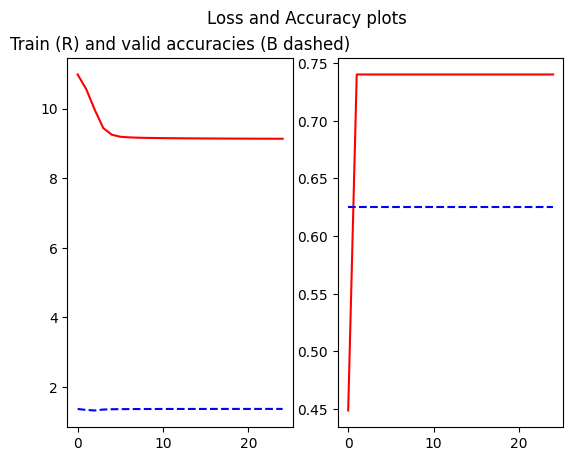

In [245]:
model = LSTM(input_size = 1, num_layers = 4, drop_rate = 0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
batch_size = 4
train_logitloss(model=model.to(device).double(), optimizer=optimizer,train_iter=train_iter, criterion =nn.BCEWithLogitsLoss(weight=weight,reduction='sum') , val_iter=val_iter, num_epochs=25)

This loss doesn't work as planned, the model is not learning better than with another loss. What is also weird, the loss is not changing from epoch to epoch a lot, so there is something wrong with the usage of this loss function in my example. 
What is also weird, depending on how the model was initialized, the model can converge to good and bad results... Learning rate change doesn't help to do anything.
Both models give similar results, converging to the same accuracy value, and the loss values are similar. 
Maybe the loss is used not correctly, but after an inspection, I do not see what is the problem can be there.

# Model check
Let's check if the model can actually classify two different functions.
One function is a sinusoid.
Another function is Morlet.
We take 200 descreet points, so that the input matches the size of our data.
We want to train our model to classify this samples into two classes, using all the same parameters, as for our patients and control data groups.


Text(0.5, 1.0, 'Random Plot of Sin data function')

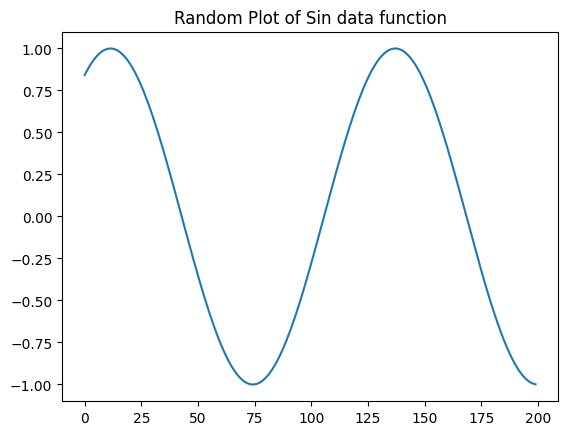

In [13]:
N = 100 # number of samples
L = 200 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
sin_samples = np.sin(x/1.0/T).astype(np.float32)
plt.plot(sin_samples[5,:])
plt.title('Random Plot of Sin data function')

Text(0.5, 1.0, 'Random Plot of Morlet real part data function')

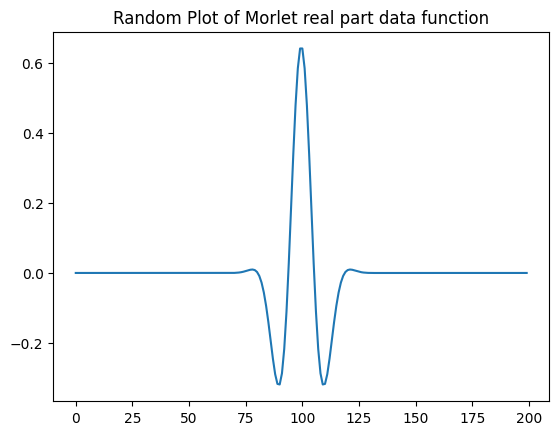

In [11]:
from scipy import signal
M = 200
T = 4.0
w = 2.0
morlet_samples = np.zeros((100,200))
for i in range(0,100):
    s = np.random.randint(-4*T, 4*T)
    wavelet = signal.morlet(M, s, w)
    morlet_samples[i,:] = wavelet.real

plt.plot(morlet_samples[5,:])
plt.title('Random Plot of Morlet real part data function')

In [22]:
X = np.vstack([sin_samples, morlet_samples])
y = [0]*100 +[1]*100

In [23]:
class SinMorletDataset(Dataset):
    """Neurogenertive features dataset."""

    def __init__(self, X,y):
        """
        Args:
            X,y of data
           
        """
        self.X=X
        self.y =y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx,:], self.y[idx]

In [24]:
dataset = SinMorletDataset(X,y)

In [60]:
model = LSTM(input_size = 1, num_layers = 4, drop_rate = 0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 4

In [61]:
from torch.utils.data import  random_split
train_data, test_data = random_split(dataset, [150,50], generator=torch.Generator().manual_seed(162))

In [62]:
# Training Function
def train(model,
          optimizer,
          train_iter,
          val_iter,
          criterion = nn.BCELoss(),
          num_epochs = 10,
          best_valid_loss = float("Inf")):
    
    eval_every = len(train_iter)
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    accuracy_train = []
    accuracy_val = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total_correct_t = 0 
        total_predicted_t = 0
        for  X, labels in train_iter:  
            labels = labels.float().to(device)
            X = torch.unsqueeze(X, dim=1)
            X = torch.transpose(X,2,1).float().to(device)
            output = model(X)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #accuracy train metric
            classifications_t = output.round() #binary accuracy
            #print(classifications_t, labels)
            correct_predictions_t = sum(classifications_t==labels).item()
            total_correct_t += correct_predictions_t
            total_predicted_t += len(labels)        

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            total_correct = 0
            total_predicted = 0
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for  X_val, y_val in val_iter:           
                      y_val = y_val.float().to(device)
                      X_val=torch.unsqueeze(X_val, dim=1)
                      X_val=torch.transpose(X_val,2,1).float().to(device)
                      output = model(X_val)
                      loss = criterion(output, y_val)
                      classifications = output.round() #binary accuracy
                      correct_predictions = sum(classifications==y_val).item()
                      total_correct += correct_predictions
                      total_predicted += len(labels)                        
                      valid_running_loss += loss.item()
                        

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(train_iter)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                accuracy_val.append(total_correct/total_predicted)
                
                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f} Accuracy: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              average_train_loss, average_valid_loss, total_correct/total_predicted))

        accuracy_train.append(total_correct_t/total_predicted_t)
        print(f'Train accuracy {total_correct_t/total_predicted_t}')
    

    print('Finished Training!')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Loss and Accuracy plots')
    ax1.title.set_text('Train (R) and valid losses (B dashed)')
    ax1.plot(train_loss_list,'r',valid_loss_list, '--b')
    ax2.plot(accuracy_train,'r', accuracy_val, '--b')  
    ax1.title.set_text('Train (R) and valid accuracies (B dashed)')


Epoch [1/25], Step [75/1875], Train Loss: 0.6958, Valid Loss: 0.2348 Accuracy: 0.4200
Train accuracy 0.5
Epoch [2/25], Step [150/1875], Train Loss: 0.5749, Valid Loss: 0.0392 Accuracy: 1.0000
Train accuracy 0.7066666666666667
Epoch [3/25], Step [225/1875], Train Loss: 0.0604, Valid Loss: 0.0027 Accuracy: 1.0000
Train accuracy 0.9933333333333333
Epoch [4/25], Step [300/1875], Train Loss: 0.0057, Valid Loss: 0.0011 Accuracy: 1.0000
Train accuracy 1.0
Epoch [5/25], Step [375/1875], Train Loss: 0.0028, Valid Loss: 0.0007 Accuracy: 1.0000
Train accuracy 1.0
Epoch [6/25], Step [450/1875], Train Loss: 0.0016, Valid Loss: 0.0002 Accuracy: 1.0000
Train accuracy 1.0
Epoch [7/25], Step [525/1875], Train Loss: 0.0007, Valid Loss: 0.0002 Accuracy: 1.0000
Train accuracy 1.0
Epoch [8/25], Step [600/1875], Train Loss: 0.0005, Valid Loss: 0.0001 Accuracy: 1.0000
Train accuracy 1.0
Epoch [9/25], Step [675/1875], Train Loss: 0.0004, Valid Loss: 0.0001 Accuracy: 1.0000
Train accuracy 1.0
Epoch [10/25], St

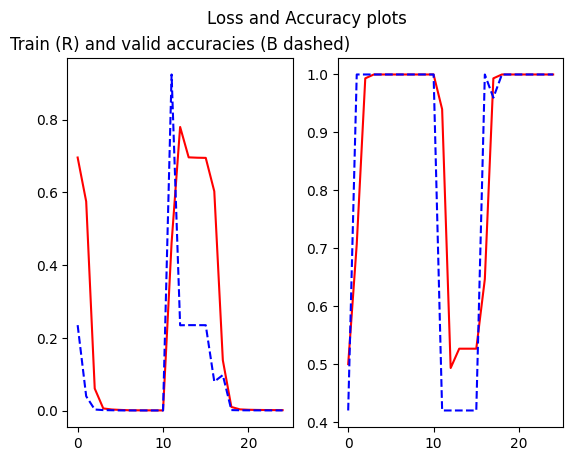

In [63]:
train(model=model.to(device).float(), optimizer=optimizer,train_iter=train_iter, val_iter=val_iter, num_epochs=25)

Model quickly learns to separate these two simple functions, so the model functions. Then moodel looses the performance, probably, the LR is way too high, but then it gains it back.
NB: maybe the two selected functions are way too simple and easy to distinguish, but still, it shows the model can learn.

#  Data augmentation
We previosly experimented with SMOTE (see the notebook SMOTE!).
Let's try to use it here as well to create new data samples for under represented class.

In [ ]:
from imblearn.over_sampling import SMOTE

## RNN network

Even simplier network than the LSTM to test. 

In [ ]:
# Different more flexible LSTM from [here](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7)

# Parameter search

Best parameter search for the network, a very extensive method but we can check if it can even work.